In [2]:
import scipy as sp
import sklearn
from sklearn.datasets import make_low_rank_matrix
from matplotlib import image
import matplotlib.pyplot as plt
import time
import numpy as np
from math import pi
import seaborn as sns
plt.rcParams['figure.figsize'] = [16, 8]

k = 1000

In [3]:
m = 200
n = 200
r = min(m,n)

eigonvals = np.logspace(0,-2,r)
D = np.zeros((r,r))
np.fill_diagonal(D,eigonvals)
rng = np.random.default_rng(12345)

U,_ = sp.linalg.qr(rng.standard_normal(size = (m,r)), mode = 'economic')
V,_ = sp.linalg.qr(rng.standard_normal(size = (n,r)), mode = 'economic')

A = U@D@V.T

In [4]:
A.shape

(200, 200)

In [5]:
#print("Rank of A is: {}".format(np.linalg.matrix_rank(A)))

In [6]:
B = sp.io.mmread('airfoil1.mtx')
B_mat = B.A
B_mat.shape

(4253, 4253)

In [7]:
#print("Rank of B is: {}".format(np.linalg.matrix_rank(B_mat)))

>### Define decomposition algorithms

In [8]:
def svd(A):
    U, S, VT = np.linalg.svd(A,full_matrices=False)
    return U, S, VT

################################################################################

def rSVD(A,k,q,p):
    
    # k Target rank
    # q Power iterations
    # p Oversampling parameter
    
    # Step 1: Sample column space of A with P matrix
    
    m, n = A.shape
    P = np.random.randn(n,k+p)
    Z = A @ P
    
    for k in range(q):
        Z = A @ (A.T @ Z)

    Q, R = np.linalg.qr(Z)

    # Step 2: Compute SVD on projected Y = Q.T @ X
    
    Y = Q.T @ A
    UY, S, VT = np.linalg.svd(Y,full_matrices=False)
    U = Q @ UY

    return U, S, VT

################################################################################

def find_range(A,L):
    #Algorithm 4.1: Randomized range finder
    m, n = A.shape
    O = np.random.randn(n,L)
    Y = A @ O
    Q , R = np.linalg.qr(Y)
    return Y, Q, R

################################################################################

def adapt_range_finder(A,e,r):
    #Algorithm 4.2: Randomized range finder
    
    e0 = 10 * np.sqrt(2 / pi)
    m,n = A.shape
    w = np.random.normal(size=(n,r))
    Y = A @ w
    Q = np.zeros((m, 1))
    j = 0
    
    while np.linalg.norm(Y[:, j+1:], axis=1).max() > e / e0 :
            j += 1
            I = np.identity(m)
            Y[:, j] = (I - Q @ Q.T) @ Y[:, j]
            q = Y[:, j] / np.linalg.norm(Y[:, j])
            Q = np.concatenate(Q, q)
            wr = np.random.normal(size=(n,r))
            Y = np.concatenate(Y, ((I - Q @ Q.T) @ (A @ wr)))
            Y[:, j+1:j+r] -= q*np.dot(q, y[:,k])
            Q = Q[:, 1:]
            
    return Y , Q


###################################################################################


def power_iter(A,L,q):
    #Algorithm 4.3: Randomized Power Iteration
    m, n = A.shape
    O = np.random.randn(n,L)
    Y = ((A @ A.T)**q) @ A @ O
    Q , R = np.linalg.qr(Y)
    return Y, Q, R


################################################################################

def subspace_iter(A,L,q):
    #Algorithm 4.4: Randomized subspace iteration
    m, n = A.shape
    O = np.random.randn(n,L)
    Y = A @ O
    Q , R = np.linalg.qr(Y)
    for i in range(q):
        Z , R = np.linalg.qr(A.T @ Q)
        Y = A @ Z 
        Q , R = np.linalg.qr(Y)
    return Y, Q, R

################################################################################

def direct_svd(A,Q):
    #Algorithm 5.1: Direct SVD
    B = Q.T @ A
    U_tilde, S, VT = np.linalg.svd(B,full_matrices=False)
    U = Q @ U_tilde
    return U, S, VT

################################################################################

def error_fact(A, U, S, Vt):
    return np.linalg.norm(A-U@np.diag(S)@Vt)/np.linalg.norm(A)

In [9]:
U, s, V = svd(B_mat)

Number of singular values: 4253
Max, min singular values: 6.029395379416093, 0.00020100290258762848


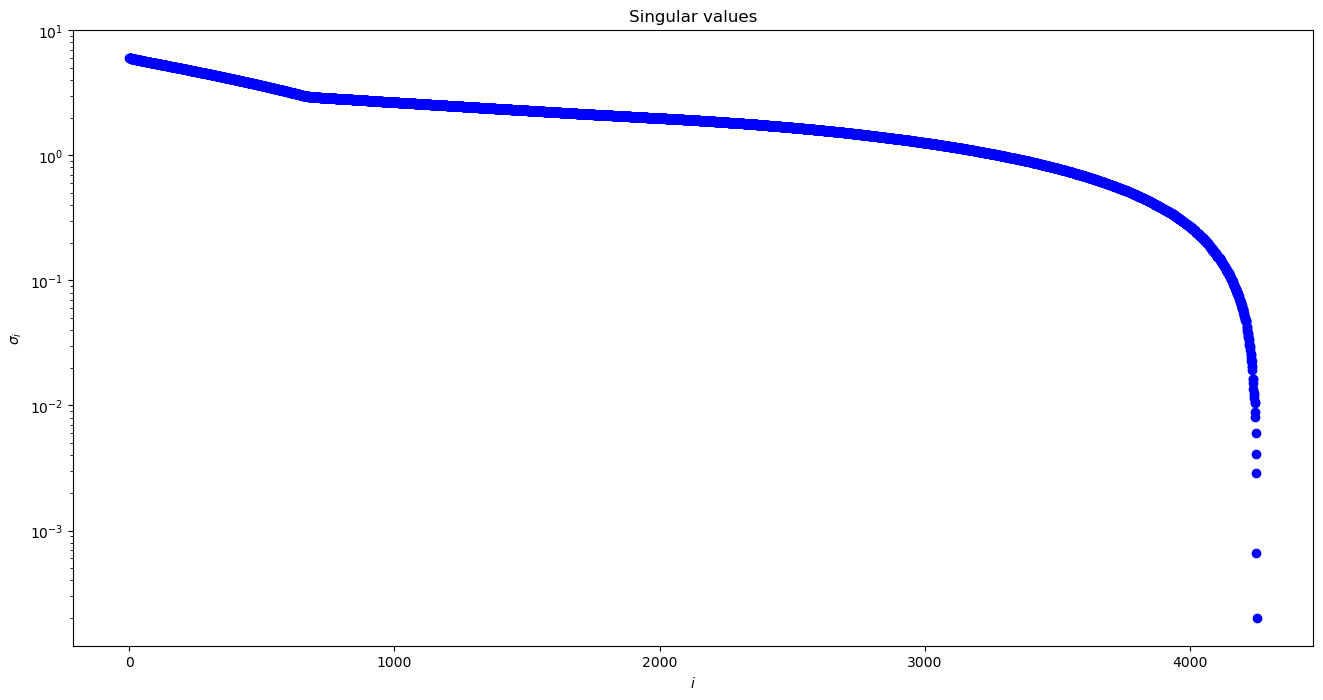

In [10]:
print("Number of singular values: {}".format(len(s)))
print("Max, min singular values: {}, {}".format(s[0], s[-1]))
plt.xlabel('$i$')
plt.ylabel('$\sigma_i$')
plt.title('Singular values')
plt.yscale('log')
plt.plot(s, 'bo');

In [11]:
U, s_, V = svd(A)

Number of singular values: 200
Max, min singular values: 0.9999999999999996, 0.010000000000000002


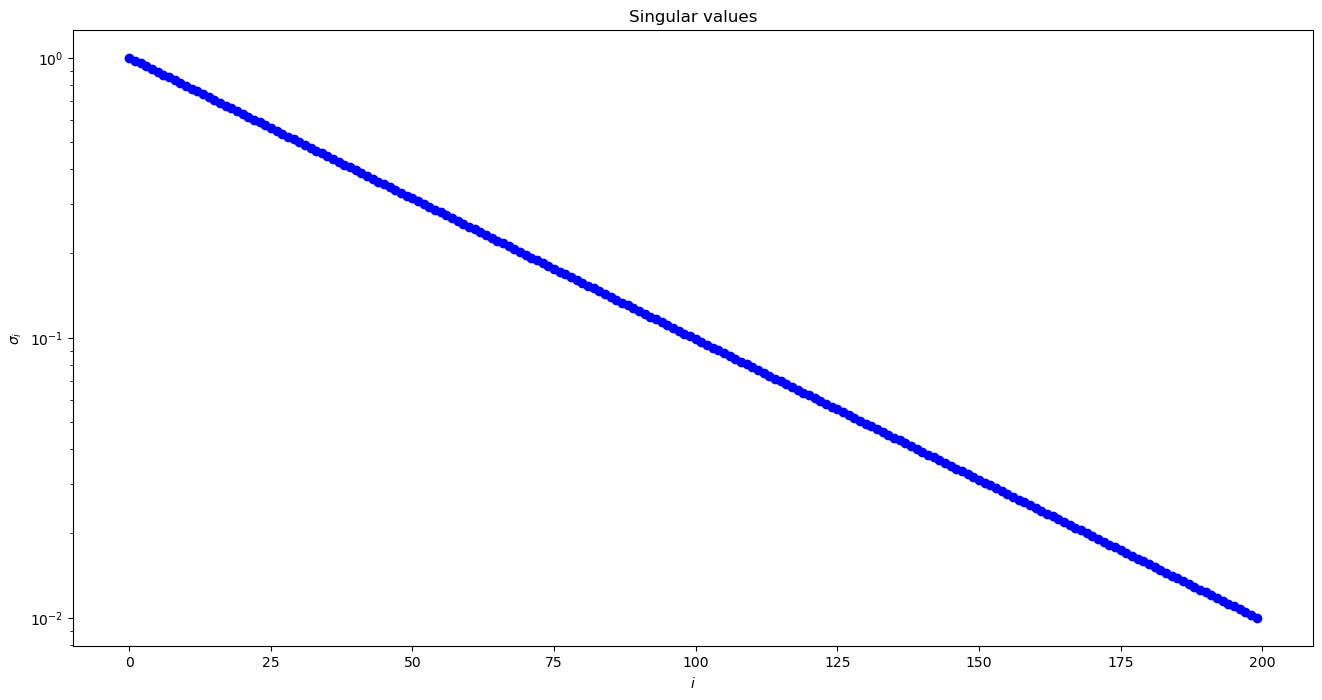

In [12]:
print("Number of singular values: {}".format(len(s_)))
print("Max, min singular values: {}, {}".format(s_[0], s_[-1]))
plt.xlabel('$i$')
plt.ylabel('$\sigma_i$')
plt.title('Singular values')
plt.yscale('log')
plt.plot(s_, 'bo');

In [15]:
%%time
start = time.time()
U,S,V = svd(B_mat)
end = time.time()

print("Error :",error_fact(B_mat, U, S, V))
print("")
print("exe time: ", end-start)

Error : 4.961585685785023e-15

exe time:  45.068907499313354
CPU times: total: 8min 20s
Wall time: 1min 12s


Text(0.5, 1.0, 'SVD')

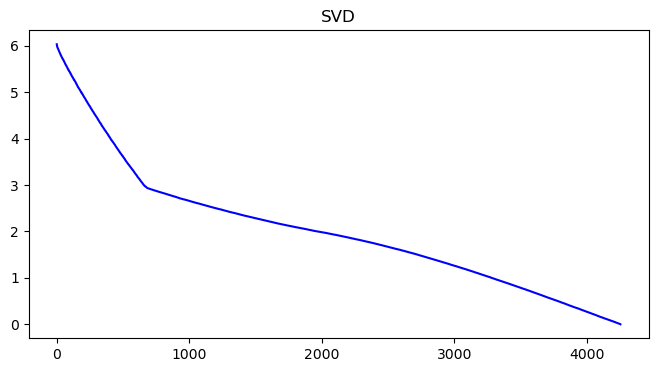

In [16]:
plt.figure(figsize=(8,4))
plt.plot(S,color = "blue",label='SVD')
plt.title('SVD')

In [17]:
%%time
start = time.time()
rU,rS,rV = rSVD(B_mat,k,2,1)
end = time.time()
print("Error :",error_fact(B_mat, rU, rS, rV))
print("")
print("exe time: ", end-start)

Error : 0.6136511833222714

exe time:  7.193305969238281
CPU times: total: 58.5 s
Wall time: 8.18 s


Text(0.5, 1.0, 'RSVD')

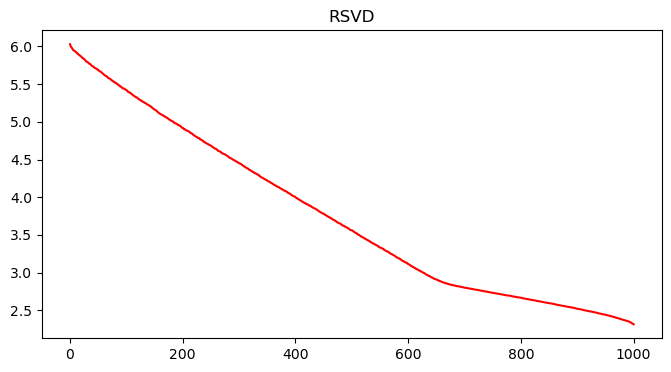

In [18]:
plt.figure(figsize=(8,4))
plt.plot(rS,color="red",label='RSVD')
plt.title('RSVD')

In [19]:
%%time
start = time.time()
Y, Q1, R = find_range(B_mat,k)
U1, S1, V1 = direct_svd(B_mat, Q1)
end = time.time()
print("Error :",error_fact(B_mat, U1, S1, V1))
print("")
print("exe time: ", end-start)

Error : 0.7423937941656717

exe time:  9.057099342346191
CPU times: total: 59 s
Wall time: 10.2 s


Text(0.5, 1.0, 'SVD : Find range')

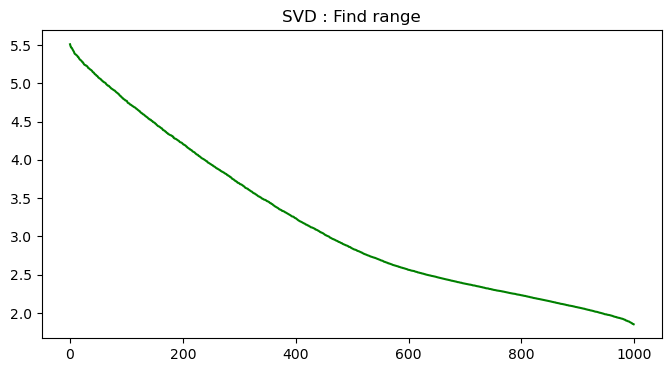

In [21]:
plt.figure(figsize=(8,4))
plt.plot(S1,color="green",label='RSVD_FR')
plt.title('SVD : Find range')

In [22]:
%%time
start = time.time()
Y, Q3, R = power_iter(B_mat,k,2)
U3, S3, V3 = direct_svd(B_mat, Q3)
end = time.time()
print("Error :",error_fact(B_mat, U3, S3, V3))
print("")
print("exe time: ", end-start)

Error : 0.6797175929867116

exe time:  15.908555269241333
CPU times: total: 2min 8s
Wall time: 17.5 s


Text(0.5, 1.0, 'SVD : Power Iteration')

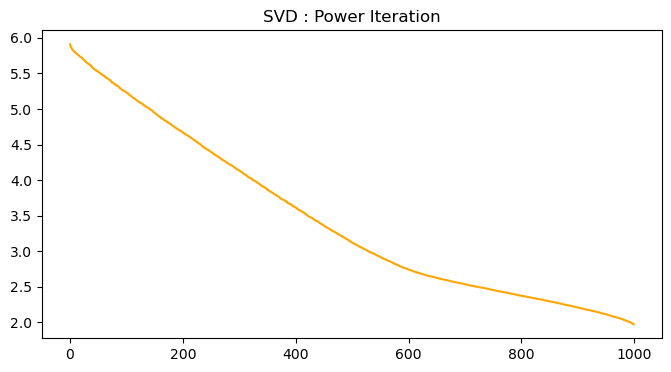

In [23]:
plt.figure(figsize=(8,4))
plt.plot(S3,color="orange",label='RSVD_PI')
plt.title('SVD : Power Iteration')

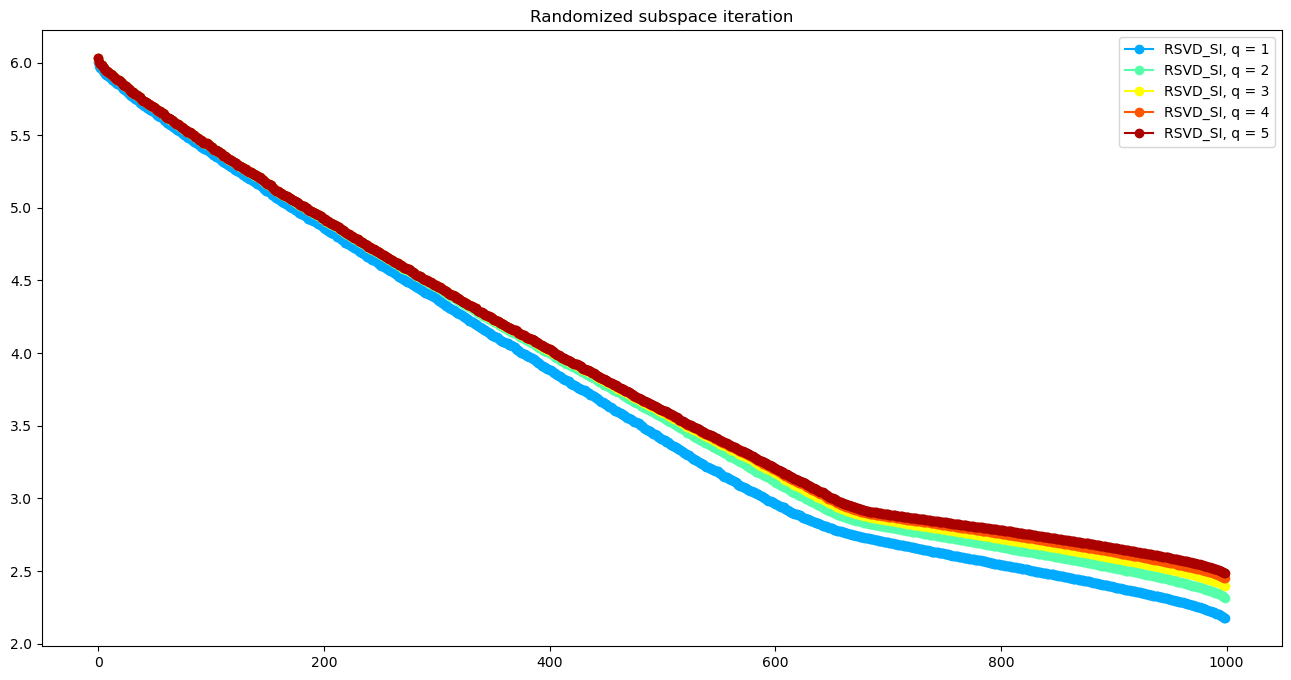

In [24]:
color_list = np.array([[0,0,2/3],  # Define color map
                 [0,0,1],
                 [0,1/3,1],
                 [0,2/3,1],
                 [0,1,1],
                 [1/3,1,2/3],
                 [2/3,1,1/3],
                 [1,1,0],
                 [1,2/3,0],
                 [1,1/3,0],
                 [1,0,0],
                 [2/3,0,0]])

#plt.plot(S,'o-',color='k',label='SVD')

Y = B_mat
for q in range(1,6):
    Y, Q4, R = subspace_iter(B_mat,1000,q)
    Uq, Sq, VTq = direct_svd(B_mat, Q4)
    #Uq, Sq, VTq = np.linalg.svd(Y,full_matrices=0)
    plt.plot(Sq,'-o',color=tuple(color_list[2*q+1]),label='RSVD_SI, q = '+str(q))

plt.title("Randomized subspace iteration")
plt.legend()
plt.show()

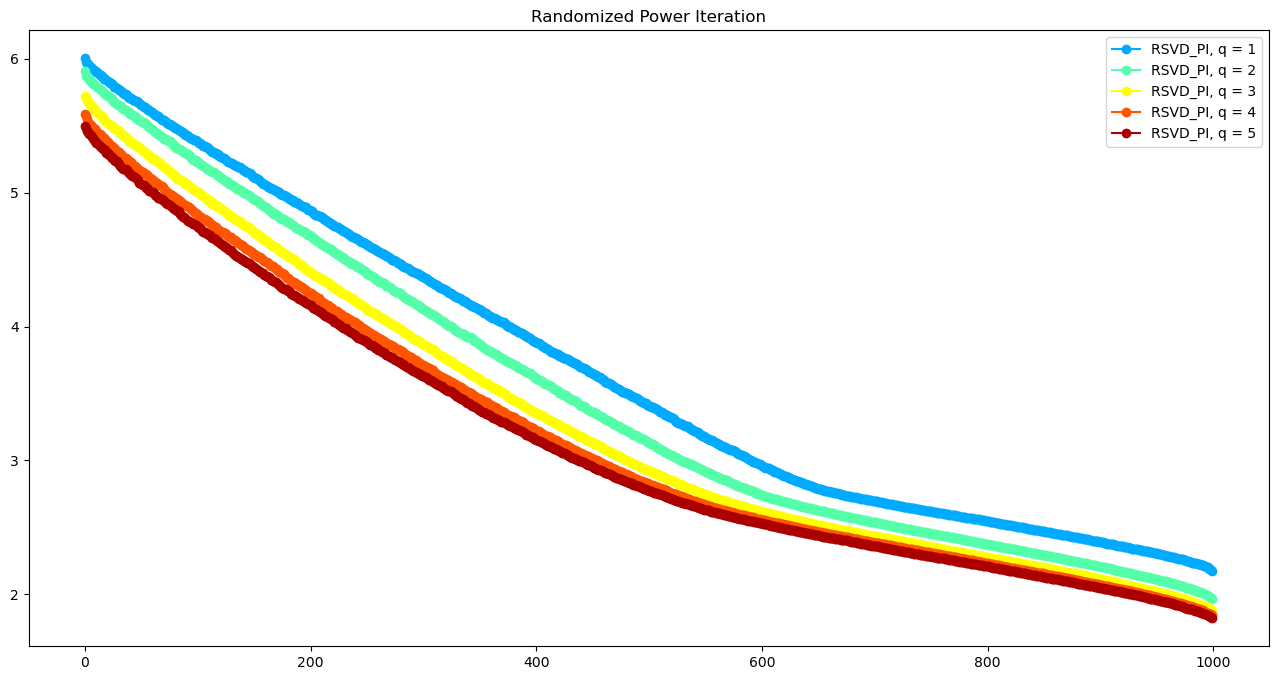

In [25]:
color_list = np.array([[0,0,2/3],  # Define color map
                 [0,0,1],
                 [0,1/3,1],
                 [0,2/3,1],
                 [0,1,1],
                 [1/3,1,2/3],
                 [2/3,1,1/3],
                 [1,1,0],
                 [1,2/3,0],
                 [1,1/3,0],
                 [1,0,0],
                 [2/3,0,0]])

#plt.plot(S,'o-',color='k',label='SVD')

Y = B_mat
for q in range(1,6):
    Y, Q4, R = power_iter(B_mat,1000,q)
    Uq, Sq, VTq = direct_svd(B_mat, Q4)
    #Uq, Sq, VTq = np.linalg.svd(Y,full_matrices=0)
    plt.plot(Sq,'-o',color=tuple(color_list[2*q+1]),label='RSVD_PI, q = '+str(q))

plt.title("Randomized Power Iteration")    
plt.legend()
plt.show()

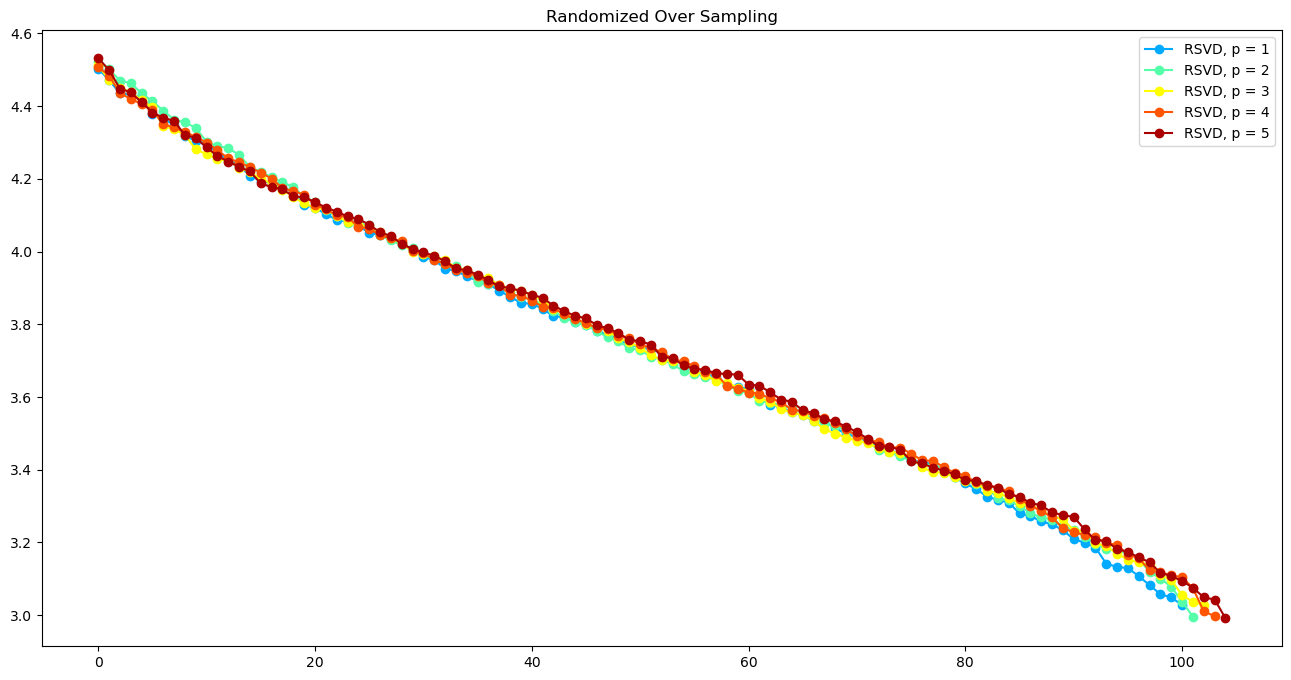

In [26]:
color_list = np.array([[0,0,2/3],  # Define color map
                 [0,0,1],
                 [0,1/3,1],
                 [0,2/3,1],
                 [0,1,1],
                 [1/3,1,2/3],
                 [2/3,1,1/3],
                 [1,1,0],
                 [1,2/3,0],
                 [1,1/3,0],
                 [1,0,0],
                 [2/3,0,0]])

#plt.plot(S,'o-',color='k',label='SVD')

Y = B_mat
for p in range(1,6):
    Uq, Sq, VTq = rSVD(B_mat,100,0,p)
    #Uq, Sq, VTq = direct_svd(B_mat, Q4)
    #Uq, Sq, VTq = np.linalg.svd(Y,full_matrices=0)
    plt.plot(Sq,'-o',color=tuple(color_list[2*p+1]),label='RSVD, p = '+str(p))

plt.title("Randomized Over Sampling")
plt.legend()
plt.show()

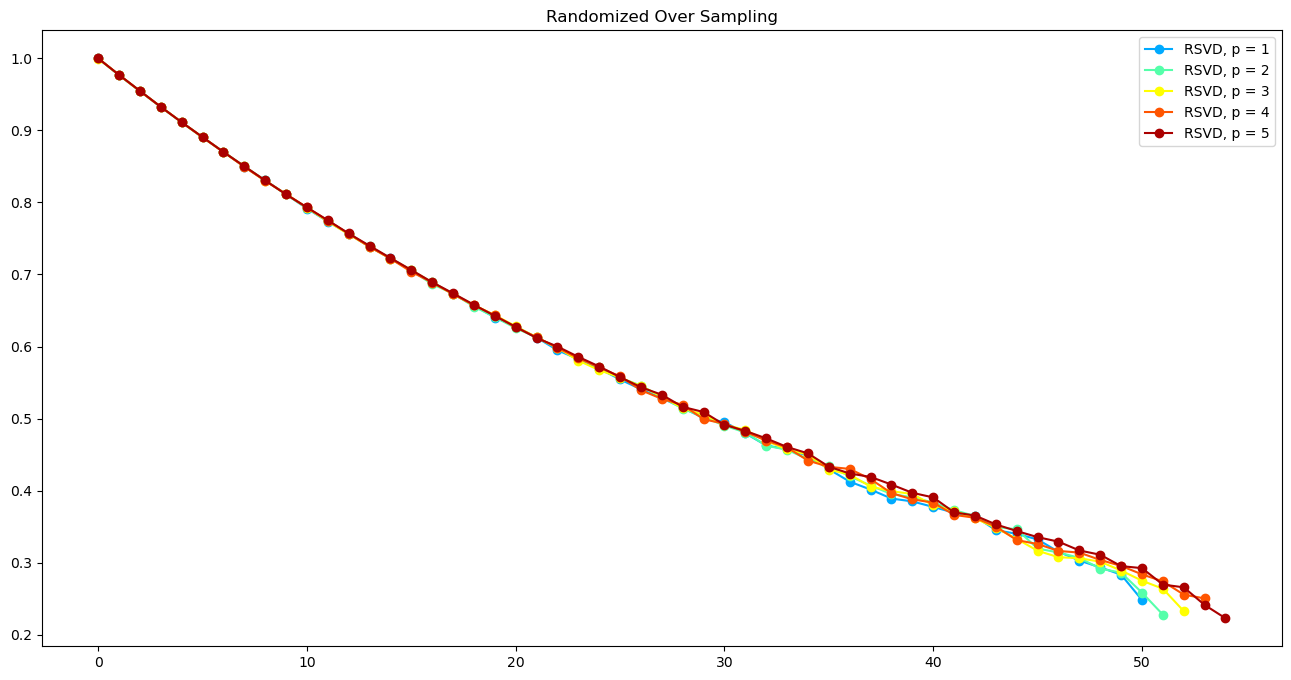

In [27]:
color_list = np.array([[0,0,2/3],  # Define color map
                 [0,0,1],
                 [0,1/3,1],
                 [0,2/3,1],
                 [0,1,1],
                 [1/3,1,2/3],
                 [2/3,1,1/3],
                 [1,1,0],
                 [1,2/3,0],
                 [1,1/3,0],
                 [1,0,0],
                 [2/3,0,0]])

#plt.plot(S,'o-',color='k',label='SVD')

Y = A
for p in range(1,6):
    Uq, Sq, VTq = rSVD(A,50,1,p)
    #Uq, Sq, VTq = direct_svd(B_mat, Q4)
    #Uq, Sq, VTq = np.linalg.svd(Y,full_matrices=0)
    plt.plot(Sq,'-o',color=tuple(color_list[2*p+1]),label='RSVD, p = '+str(p))

plt.title("Randomized Over Sampling")
plt.legend()
plt.show()

In [28]:
def cpqr(A):
    Q, R, P = linalg.qr(a, pivoting=True)
    return Q, R, P

In [29]:
def c(A,k):
    m, n = A.shape
    G = np.random.randn(n,k)
    Y = A @ G
    Q , R = np.linalg.qr(Y)
    if A is A.T :
        C = Q.T @ A @ Q
    else:
        C = np.zeros((Q.T.shape[0], Q.shape[0])) # Default value
        print(f"{A} is not equal to {A.T}")
    return C , Q

In [30]:
def single_pass(A,k,p):
    m, n = A.shape
    G = np.random.randn(n,k)
    Y = A @ G
    Q , R = np.linalg.qr(Y)
    B = Q.T @ A
    U_tilde, S, VT = np.linalg.svd(B,full_matrices=False)
    U = Q @ U_tilde
    return U, S, VT

In [31]:
def single_pass_c(A,k,p):
    C , Q = c(A,k)
    D, U_tilde = np.linalg.eig(C)
    U = Q @ U_tilde
    return U, D

In [35]:
U, S, VT = single_pass(B_mat,100,1)